### Load Model

In [1]:
%cd ../code

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as tf
from dorsalnet import DorsalNet

DEVICE = 'cuda:0'
DTYPE = torch.bfloat16

model = DorsalNet(False, 32).eval().to(DEVICE).to(DTYPE)
model.load_state_dict(torch.load('/home/matthew/Data/DorsalNet_FC/base_models/DorsalNet/pretrained.pth'))

/home/matthew/Code/DorsalNet_FC/code


<All keys matched successfully>

### Load Images

Model input size = (batch_size, 3, 32, height, width)

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

preprocess = tf.Compose([
    tf.Resize(112),
    tf.ToTensor(),
    # tf.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
])

dl = DataLoader(ImageFolder('/home/matthew/Data/DorsalNet_FC/stimuli/NaturalMovies/images/trn', transform=preprocess), batch_size=32, shuffle=False)

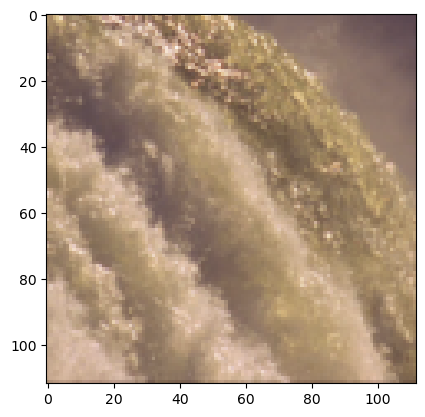

In [3]:
# Show example
for batch, label in dl:
    batch = batch.permute(1,0,2,3).unsqueeze(0)
    break

from matplotlib import pyplot as plt
plt.imshow(batch[0,:,24].moveaxis(0,-1).cpu())

### Choose downsampling

In [4]:
import torch
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm
from functools import partial
from collections import defaultdict
import dill as pickle
from math import factorial

def iterate_children(child, parent_name='model', depth=1):
    if depth > 1:
        children_list = []
        for name, grandchild in child.named_children():
            children_list += iterate_children(grandchild, parent_name+'.'+name, depth-1)
        return children_list
    else:
        return {(parent_name+'.'+name, module) for name, module in child.named_children()}

def store_activations(activations_dict, layer_name, module, input, output):
    activations_dict[layer_name] = output

def hook_model(model, depth):
    model.activations = defaultdict(list)
    for layer_name, child in iterate_children(model, depth=depth):
        child.register_forward_hook(partial(store_activations, model.activations, layer_name))
    return model

def choose_downsampling(activations, max_fs):
    if activations.ndim == 5:
        activations = activations[0:1]
        test_range = activations.shape[-1]
        numels = np.zeros((test_range+1, test_range))
        pbar = tqdm(range(sum(range(test_range+1))))
        for k in range(1,test_range+1):
            for s in range(1,k+1):
                pbar.update(1)
                pbar.set_postfix_str(f"testing size {k}, stride {s}")
                n = (activations.shape[-1] - k) / s
                if n != int(n):
                    continue
                else:
                    pooled = torch.nn.functional.max_pool3d(activations, kernel_size=(2,k,k), stride=s)
                    if pooled.shape[-1] > 1 and pooled.numel() <= max_fs:
                        numels[k,s] = pooled.numel()
                    else:
                        continue
        best_k, best_s = np.unravel_index(np.argmax(numels, axis=None), numels.shape)
        if (best_k, best_s) == (0,0):
            return None
        else:
            return torch.nn.MaxPool3d(kernel_size=(2, best_k, best_k), stride=best_s)
    else:
        return None

In [5]:
MAX_FS = 1500

model = hook_model(model, 1)
model(batch.to(DEVICE).to(DTYPE))

layer_downsampling_fns = {}
for layer_name, layer_activations in model.activations.items():
    print('**************')
    print(layer_name)
    print('old_shape:', layer_activations.flatten().shape)
    layer_downsampling_fn = choose_downsampling(layer_activations, MAX_FS)
    layer_downsampling_fns[layer_name] = layer_downsampling_fn
    if layer_downsampling_fn is not None:
        layer_activations = layer_downsampling_fns[layer_name](layer_activations)
    print('new_shape:', layer_activations.flatten().shape)

**************
model.conv1
old_shape: torch.Size([6422528])


  0%|          | 0/1596 [00:00<?, ?it/s]

new_shape: torch.Size([1280])
**************
model.s1
old_shape: torch.Size([1605632])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1280])
**************
model.res0
old_shape: torch.Size([802816])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1440])
**************
model.res1
old_shape: torch.Size([802816])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1440])
**************
model.res2
old_shape: torch.Size([802816])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1440])
**************
model.res3
old_shape: torch.Size([802816])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1440])
**************
model.concat
old_shape: torch.Size([2408448])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1152])
**************
model.dropout
old_shape: torch.Size([802816])


  0%|          | 0/406 [00:00<?, ?it/s]

new_shape: torch.Size([1440])


### Initialize FC Layer

In [6]:
import torch.nn as nn

class FC(nn.Module):
    def __init__(self, n_voxels):
        super().__init__()
        self.linear = nn.LazyLinear(out_features=n_voxels)

    def forward(self, x):
        x = self.linear(x)
        return x

subject_id = 'S00'
trn_brain = np.load(f'/home/matthew/Data/DorsalNet_FC/fMRI_data/{subject_id}/NaturalMovies/trn.npy')
trn_brain = torch.tensor(np.nan_to_num(trn_brain), device=DEVICE)
n_voxels = trn_brain.shape[1]

fc = FC(n_voxels).to(DEVICE).to(DTYPE)
print(fc)

FC(
  (linear): LazyLinear(in_features=0, out_features=9853, bias=True)
)


/home/matthew/anaconda3/envs/DorsalNet_FC/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Train

In [7]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.optim import Adam

augmentations=tf.Compose([
    tf.RandomCrop(size=batch.shape[-1], padding=2),
    # tf.RandomRotation(degrees=[-1,1], expand=False),
])

import plotly.graph_objects as go

def losses_plot(losses, fig, epoch_i):
    fig.data[epoch_i].y = losses

fig = go.FigureWidget()
fig.add_scatter()
fig.update_xaxes(range=[0, 3600])
fig.update_layout(xaxis_title="Sample", yaxis_title="Loss")
fig

In [ ]:
torch.cuda.empty_cache()
optimizer = Adam(fc.parameters(), lr=0.1)

dl = DataLoader(ImageFolder('/home/matthew/Data/DorsalNet_FC/stimuli/NaturalMovies/images/trn', transform=preprocess), batch_size=30, shuffle=False)
for epoch in range(50):
    pbar = tqdm(enumerate(dl), total=len(trn_brain), desc=f"Epoch {epoch}")
    epoch_losses = []
    for i, (batch, label) in pbar:
        batch = batch.permute(1,0,2,3).unsqueeze(0).to(DTYPE)
        batch = torch.cat([batch[:,:,0:1], batch, batch[:,:,-1:]], dim=2)
        augmentations(batch[0]).unsqueeze(0)
        optimizer.zero_grad()
        model.forward(batch.to(DEVICE))
        all_activations = []
        for layer_name, layer_activations in model.activations.items():
            layer_downsampling_fn = layer_downsampling_fns[layer_name]
            if layer_downsampling_fn is not None:
                layer_activations = layer_downsampling_fn(layer_activations)
            all_activations.append(layer_activations.mean(0).flatten())
            model.activations[layer_name] = 0
        fc_out = fc(torch.cat(all_activations).unsqueeze(0))
        batch_brain = (trn_brain[min(i+2, len(trn_brain)-1)] + trn_brain[min(i+3, len(trn_brain)-1)]) / 2
        loss = torch.square(fc_out[0]/1000 - batch_brain).sum().sqrt()
        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f"Loss: {loss.item():.2f}")
        epoch_losses.append(loss.item())
        losses_plot(epoch_losses, fig)
    print(f"Mean Epoch Loss: {torch.mean(torch.tensor(epoch_losses)).item():.2f}")

Epoch 0:   0%|          | 0/3600 [00:00<?, ?it/s]

### Alt version: compute gradients for who, standardized dataset

In [ ]:
# trn_brain_lagged = (trn_brain[2:-1] + trn_brain[3:]) / 2

# optimizer = Adam(fc.parameters(), lr=0.1)

# dl = DataLoader(ImageFolder('/home/matthew/Data/DorsalNet_FC/stimuli/NaturalMovies/images/trn', transform=preprocess), batch_size=30, shuffle=False)
# for epoch in range(50):
#     torch.cuda.empty_cache()
#     optimizer.zero_grad()
#     epoch_outputs = []
#     pbar = tqdm(enumerate(dl), total=len(trn_brain), desc=f"Epoch {epoch}")
#     for i, (batch, label) in pbar:
#         batch = batch.permute(1,0,2,3).unsqueeze(0).to(DTYPE)
#         batch = torch.cat([batch[:,:,0:1], batch, batch[:,:,-1:]], dim=2)
#         augmentations(batch[0]).unsqueeze(0)
#         model.forward(batch.to(DEVICE))
#         all_activations = []
#         for layer_name, layer_activations in model.activations.items():
#             layer_downsampling_fn = layer_downsampling_fns[layer_name]
#             if layer_downsampling_fn is not None:
#                 layer_activations = layer_downsampling_fn(layer_activations)
#             all_activations.append(layer_activations.mean(0).flatten())
#             model.activations[layer_name] = 0
#         epoch_outputs.append(fc(torch.cat(all_activations).unsqueeze(0)))
#     epoch_outputs = torch.tensor(epoch_outputs)[:-3]
#     epoch_outputs -= epoch_outputs.mean(0)
#     epoch_outputs /= epoch_outputs.std(0)
#     loss = torch.linalg.norm(trn_brain_lagged - epoch_outputs, ord='fro')
#     loss.backward()
#     optimizer.step()
#     print("Epoch loss:", loss.item())

Epoch 0:   0%|          | 0/3600 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 142.00 MiB (GPU 0; 10.76 GiB total capacity; 8.96 GiB already allocated; 159.19 MiB free; 9.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF